# Orbit Propagation
## Hand made function

In [24]:
from scipy.integrate import solve_ivp
import numpy as np

def dynamics(t, xv):
    mu = 398600
    x = xv[:3]
    v = xv[3:]
    xdotvdot=[]
    xdotvdot[:3] = v
    vdot = (-mu/np.linalg.norm(x)**3)
    xdotvdot[3:] = [xi * vdot for xi in x]
    return xdotvdot

r = [-246.455751500585, 7144.97666047531, 13.5146332799517]
v = [-2.30736637412123, -0.0908428037716378, 7.11468072166050]

rv = r+v

sol = solve_ivp(dynamics, [0, 3600*24], rv, rtol=1e-9, atol=1e-9, dense_output=True)

In [54]:
r = sol.y[:3]
t = sol.t

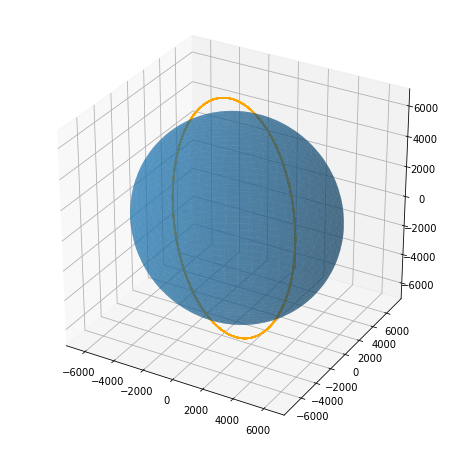

In [57]:
fig = plt.figure(figsize=(8, 8))
ax = fig.gca(projection='3d')
# ax.view_init(elev=9, azim=26)


# Make data
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = 6378 * np.outer(np.cos(u), np.sin(v))
y = 6378 * np.outer(np.sin(u), np.sin(v))
z = 6371 * np.outer(np.ones(np.size(u)), np.cos(v))

# Plot the surface
ax.plot_surface(x, y, z, alpha=0.5)

plt.plot(r[0],r[1],r[2], 'orange')

## Adding earth rotation

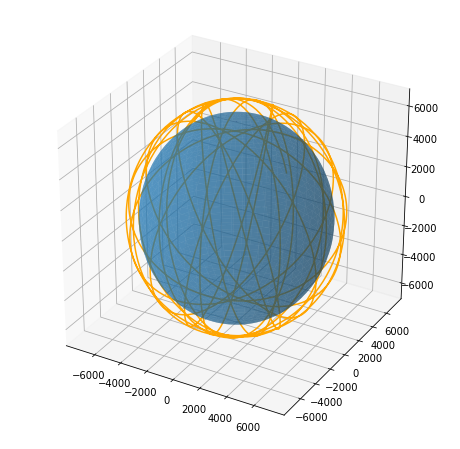

In [58]:
def cart2sph(x,y,z):
    azimuth = np.arctan2(y,x)
    elevation = np.arctan2(z,np.sqrt(x**2 + y**2))
    r = np.sqrt(x**2 + y**2 + z**2)
    return azimuth, elevation, r

def sph2cart(azimuth,elevation,r):
    x = r * np.cos(elevation) * np.cos(azimuth)
    y = r * np.cos(elevation) * np.sin(azimuth)
    z = r * np.sin(elevation)
    return x, y, z

azimuth,elevation,d = cart2sph(r[0],r[1],r[2])
azimuth=azimuth-7.25*10**-5*sol.t
r1,r2,r3 = sph2cart(azimuth,elevation,d)

fig = plt.figure(figsize=(8, 8))
ax = fig.gca(projection='3d')
ax.plot_surface(x,y,z, alpha=0.5)
plt.plot(r1,r2,r3, 'orange')

# TLE to SV and SV to TLE

In [ ]:
# function [r,v]=getSVfromTLE(i,W,e,w,M,n)
# %all deg
# %n in revs per day
# mu=398600;
# n=n/24/3600*2*pi;
# a=(mu/n^2)^(1/3);
# E=kepler(M/180*pi,e);
# rm=a*(1-e*cos(E));
# f=2*atand(tan(E/2)/((1-e)/(1+e))^0.5);
# p=a*(1-e^2);

# rw=[rm*cosd(f); rm*sind(f); 0];
# vw=(mu/p)^0.5*[-sind(f); e+cosd(f); 0];

# R(1,1)=cosd(W)*cosd(w)-sind(W)*sind(w)*cosd(i);
# R(1,2)=-cosd(W)*sind(w)-sind(W)*cosd(w)*cosd(i);
# R(1,3)=sind(W)*sind(i);
# R(2,1)=sind(W)*cosd(w)+cosd(W)*sind(w)*cosd(i);
# R(2,2)=-sind(W)*sind(w)+cosd(W)*cosd(w)*cosd(i);
# R(2,3)=-cosd(W)*sind(i);
# R(3,1)=sind(w)*sind(i);
# R(3,2)=cosd(w)*sind(i);
# R(3,3)=cosd(i);

# r=R*rw;
# v=R*vw;

# end

In [ ]:
# function [e,i,n,W,w,M]=getTLEOEfromRV(r,v)
# mu=398600;

# e_vector=((norm(v)^2-mu/norm(r))*r-(dot(r,v)*v))/mu;
# e=norm(e_vector);

# h=cross(r,v);
# i=acosd(h(3)/norm(h));

# a=norm(h)^2/mu/(1-e^2);
# n=(mu/a^3)^0.5;
# n=n*24*3600/2/pi;

# normal_vector=cross([0 0 1],h);
# W=acosd(normal_vector(1)/norm(normal_vector));

# w=acosd(dot(normal_vector,e_vector)/norm(normal_vector)/e);

# if normal_vector(2)<0
#     W=360-W;
# end
# if e_vector(3)<0
#     w=360-w;
# end


# f=acosd(dot(e_vector,r)/norm(e)/norm(r));
# E=2*atan(((1-e)/(1+e))^0.5*tan(f/2));
# M=E-e*sin(E);
# M=M/pi*180;


# end

## Kepler and Gauss

## Ground tracks

## Orbit Prop J2

## Polyastro